# Initializations

In [4]:
import gym
import torch
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum
from collections import deque
from random import random
from copy import deepcopy
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from operator import add
from torch.distributions.categorical import Categorical
from IPython.display import display, clear_output
from enum import Enum

In [5]:
torch.cuda.is_available()

False

# Actor-Critic model

## Define actor and critic architectures

In [6]:

class FCNet(nn.Module):

    def __init__(self, input_size, output_size, hsize=100, last_activation=None):
        super(FCNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hsize)
        self.fc2 = nn.Linear(hsize, hsize)
        
        #
        self.fcx = nn.Linear(hsize, hsize)
        
        self.fc3 = nn.Linear(hsize, output_size)
        self.last_activation = last_activation
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fcx(x))
        
        if self.last_activation:
            x = F.softmax(self.fc3(x), dim=1)
        else:
            x = self.fc3(x)
        
        return x

## Define Q actor-critic agent

In [7]:

class QActorCritic:
    def __init__(self, tau, buffer_size, gamma, actor_lr, critic_lr, state_size, action_size, batch_size,
                 device, warmup_step=1000, hsize=100, verbose=0, critic_warmup=5000, eps=0.5, min_eps=0.05):

        self.max_buffer_size = buffer_size
        self.gamma = torch.tensor(gamma)
        
        self.buffer = deque()
        self.action_size = action_size
        self.state_size = state_size
        self.critic_warmup = critic_warmup
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.tau = tau
        self.min_eps = min_eps
        self.eps = eps
        
        self.q = FCNet(state_size, action_size, hsize)
        self.q_target = FCNet(state_size, action_size, hsize)
        self.q.to(self.device)
        self.q_target.to(self.device)
        self.q_target.load_state_dict(self.q.state_dict())
        self.critic_opt = optim.Adam(self.q.parameters(), lr=critic_lr)
        
        self.actor = FCNet(state_size, action_size, hsize, last_activation='softmax')
        self.actor_target = FCNet(state_size, action_size, hsize, last_activation='softmax')
        self.actor.to(self.device)
        self.actor_target.to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        
        self.update_step = 0
        self.warmup_step = warmup_step
        
        
        
    def get_q_val(self, qnet, state, action=None):
        if action is None:
            return qnet(state)
        return qnet(state).gather(1, action.reshape(-1,1).long())
        
    def add_to_buffer(self, experience):
        if len(self.buffer) >= self.max_buffer_size:
            self.buffer.pop()
        self.buffer.appendleft(experience)
        
    def _np_to_tensor(self, nparrs):
        return [torch.from_numpy(arr).float().to(self.device) for arr in nparrs]
        
    def sample_minibatch(self):
        idxs = np.random.randint(0, len(self.buffer), self.batch_size)
        sample = [self.buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*sample)))
        return tuple(self._np_to_tensor([states, actions, rewards, next_states, dones]))
        
    def get_action(self, state, det=False):
        """
        if det=False it will sample based on output probabilities of policy function
        """
#         state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            if not det:
                dist = Categorical(self.policy(state))
                actions = dist.sample()
            else:
                actions = torch.argmax(self.policy(state), dim=1)
            
            return actions
        
    def get_target_action(self, state, det=False):
        with torch.no_grad():
            if not det:
                dist = Categorical(self.actor_target(state))
                actions = dist.sample()
            else:
                actions = torch.argmax(self.actor_target(state), dim=1)
            
            return actions
        
    def get_single_action(self, state, det=False):
        if self.update_step < self.critic_warmup:
            return np.random.randint(self.action_size)
        
        if (random() < self.eps and not det):
            return np.random.randint(self.action_size)
        
        state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            if not det:
                dist = Categorical(self.policy(state))
                action = dist.sample()
            else:
                action = torch.argmax(self.policy(state), dim=1)
            
        return action.cpu().numpy()[0]
    
    def policy(self, state):
        return self.actor(state)
    
    def synchronize(self):
        with torch.no_grad():
            params = self.q.parameters()
            targ_params = self.q_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
                
            params = self.actor.parameters()
            targ_params = self.actor_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
            
        
    def update_critic(self, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
        with torch.no_grad():
            last_step_target = batch_dones * batch_rewards
                        
            next_actions = self.get_target_action(batch_next_states, det=False)
            
            middle_step_target = (1-batch_dones)*(batch_rewards + self.gamma*self.get_q_val(self.q_target, batch_next_states, next_actions).squeeze())
            targets =  last_step_target + middle_step_target
        
        predictions = self.get_q_val(self.q, batch_states, batch_actions).squeeze()
        loss = F.mse_loss(predictions, targets)
        self.critic_opt.zero_grad()
        loss.backward()
        self.critic_opt.step()
        
        self.synchronize()
        
        return loss.detach().cpu().numpy()
    

    def update_actor(self, batch_states):
#         with torch.no_grad():
#             q_vals = self.get_q_val(self.q_target, batch_states, batch_actions).squeeze()

        actions = self.get_action(batch_states, det=False)
        with torch.no_grad():
            q_vals = self.get_q_val(self.q, batch_states, actions).squeeze()
            
        action_probs = self.policy(batch_states)
        action_logprobs = torch.clip(Categorical(action_probs).log_prob(actions), min=-10, max=10)
        
        loss = -torch.mean(q_vals*action_logprobs)
        
        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
        
        return loss.detach().cpu().numpy()
    
    
    def update(self, state, action, reward, next_state, done):
        self.update_step += 1
    
        self.add_to_buffer([state, action, reward, next_state, done])
        
        #TODO: warmup. should be configurable.
        if len(self.buffer) < self.warmup_step:
            return None, None         


        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = self.sample_minibatch()

        if self.update_step < self.critic_warmup:
            critic_loss = self.update_critic(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
            return None, critic_loss

        if done:
            self.eps = max(self.min_eps, self.eps*0.999)
        
        critic_loss = self.update_critic(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
        actor_loss = self.update_actor(batch_states)
        
        return actor_loss, critic_loss


# Gridworld

## defining environment

In [7]:
class WorldObj:
    def __init__(self, name):
        self.name = name
        
    def __repr__(self):
        return " "
    
class Empty(WorldObj):
    def __init__(self):
        super().__init__('empty')
    
class Log(WorldObj):
    def __init__(self):
        super().__init__('log')
    
    def __repr__(self):
        return '_'
    
class Gold(WorldObj):
    def __init__(self):
        super().__init__('gold')
    
    def __repr__(self):
        return 'G'
    
class Food(WorldObj):
    def __init__(self):
        super().__init__('food')
    
    def __repr__(self):
        return '8'
    
    
class Trap(WorldObj):
    def __init__(self):
        super().__init__('trap')
        self.state = None
    
    def __repr__(self):
        return 'X'

class Teleport(WorldObj):
    def __init__(self, dest, chance=0.8):
        super().__init__('teleport')
        self.destination = dest
        self.chance = chance
    
    def __repr__(self):
        return 'T'
    
    
class Stream(WorldObj):
    """
    stream only goes down or right!
    """
    
    def __init__(self, _dir: int):
        super().__init__('stream')
        self.dir = _dir
    
    def __repr__(self):
        return '~'
    
class Miner(WorldObj):
    def __init__(self):
        super().__init__('miner')
    
    def __repr__(self):
        return '*'
        

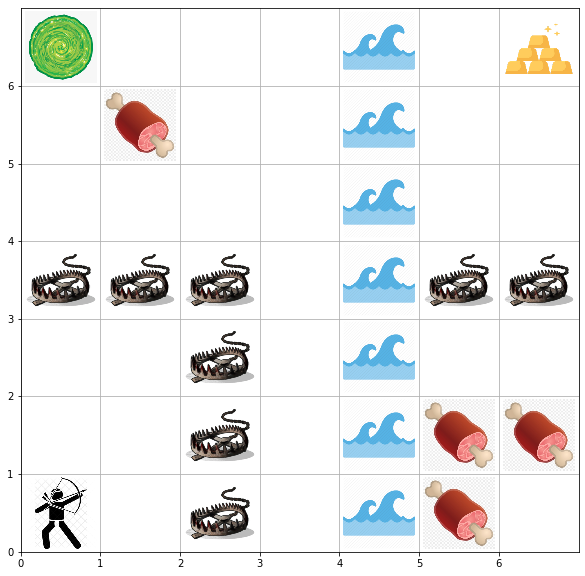

In [8]:
class Action(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3
    LOG_RIGHT = 4
    LOG_DOWN = 5
    LOG_LEFT = 6
    LOG_UP = 7
    
    

class GoldHuntEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}
    static_map_size = 7
    movement_acts = [Action.RIGHT, Action.LEFT, Action.DOWN, Action.UP,]
    craft_acts = [Action.LOG_RIGHT, Action.LOG_LEFT, Action.LOG_DOWN, Action.LOG_UP,]

    def __init__(self, ascii_rep=True, food_prob=0.6, teleport_prob=0.8):
        self.ascii_rep = ascii_rep
        self.action_space = gym.spaces.Discrete(8)
        self.observation_space = gym.spaces.Box(-1, 1, shape=(2,))
        self.info = {}
        self.static_map_size = 7
        self.max_time_step = self.static_map_size * 4
        self.max_reward_size = 10
        self.food_reward = 5 / self.max_reward_size
        self.gold_reward = 10 / self.max_reward_size
        self.time_punishment = -1 / self.max_reward_size
        self.trap_falling_reward = -5 / self.max_reward_size
        self.craft_log_reward = -3 / self.max_reward_size
        self.gold_loc = [6, 6]
        self.food_prob = food_prob
        self.teleport_prob = teleport_prob
        
    def generate_static_map(self, agent_pos):
        env_map = [[Empty() for _ in range(self.map_size)] for _ in range(self.map_size)]
        
        env_map[2][0] = Trap()
        env_map[2][1] = Trap()
        env_map[2][2] = Trap()
        env_map[2][3] = Trap()
        env_map[1][3] = Trap()
        env_map[0][3] = Trap()
        env_map[5][3] = Trap()
        env_map[6][3] = Trap()
        
        env_map[self.gold_loc[0]][self.gold_loc[1]] = Gold()
        
        if self.teleport_prob > 0:
            env_map[0][6] = Teleport(dest=[6,0])
            
        env_map[4][0] = Stream(_dir=Action.LEFT.value)
        env_map[4][1] = Stream(_dir=Action.LEFT.value)
        env_map[4][2] = Stream(_dir=Action.LEFT.value)
        env_map[4][3] = Stream(_dir=Action.LEFT.value)
        env_map[4][4] = Stream(_dir=Action.LEFT.value)
        env_map[4][5] = Stream(_dir=Action.LEFT.value)
        env_map[4][6] = Stream(_dir=Action.LEFT.value)
        
            
        return env_map

    def get_pos_obj(self, pos):
        return self.env_map[pos[0]][pos[1]]

    def stochastic_generation(self, pos, obj, prob):
        if random() < prob:
            self.env_map[pos[0]][pos[1]] = obj
    
    def _get_next_pos(self, current_loc, action):
        action_dir = Action(action)
        next_pos = copy(current_loc)
        
        if action_dir not in self.movement_acts:
            return current_loc
        
        if action_dir == Action.RIGHT:
            next_pos[1] = self._restricted_move(next_pos[1], 1)
        elif action_dir == Action.LEFT:
            next_pos[1] = self._restricted_move(next_pos[1], -1)
        elif action_dir == Action.UP:
            next_pos[0] = self._restricted_move(next_pos[0], -1)
        elif action_dir == Action.DOWN:
            next_pos[0] = self._restricted_move(next_pos[0], 1)
            
        return next_pos
        
        
    def _restricted_move(self, init_val, res):
        new_val = init_val + res
        if new_val >= self.map_size:
            new_val = self.map_size - 1
        elif new_val < 0:
            new_val = 0
        return new_val
    
    
    def pos_to_state(self, pos):
        mapped_pos = [0, 0]
        mapped_pos[0] = pos[0] / (self.map_size/2) - 1
        mapped_pos[1] = pos[1] / (self.map_size/2) - 1
        return np.array(mapped_pos)
    
    def on_border(self, pos):
        if pos[0] == 0 or pos[0] == self.map_size-1 or pos[1] == 0 or pos[1] == self.map_size-1:
            return True
        return False
    
    
    def craft_log(self, current_pos, action: int):
        """
        returns True if log is crafted, False otherwise
        """
        log_loc = self._get_next_pos(current_pos, action-4)
        if log_loc == current_pos or log_loc == self.gold_loc:
            return False
        
        self.agent_pos = log_loc
        self.env_map[log_loc[0]][log_loc[1]] = Log()
        return True
    
    def generate_stochastic_elements(self):
        self.stochastic_generation([1,6], Food(), self.food_prob)
        self.stochastic_generation([0,5], Food(), self.food_prob)
        self.stochastic_generation([1,5], Food(), self.food_prob)
        self.stochastic_generation([5,1], Food(), self.food_prob)
        self.stochastic_generation([5,0], Food(), self.food_prob)
        self.stochastic_generation([6,1], Food(), self.food_prob)
    
    def step(self, action: int):
        self.info['statu'] = ""
        self.info['step'] = self.time_step
        self.time_step += 1
        
        done = self.time_step > self.max_time_step 
        reward = self.time_punishment
        
        self.info['action'] = f"agent performed {Action(action)}"
        curr_obj = self.get_pos_obj(self.agent_pos)
        
        # agent was trapped before
        if isinstance(curr_obj, Trap) and Action(action) in self.movement_acts:
            # this part shows that trap needs memory 
            #             trap_state = curr_obj.state
#             if trap_state is None or action != (trap_state+2)%4:
#                 self.info['status'] = f"Agent in trap with previous action of {None if curr_obj.state is None else Action(curr_obj.state)}"
#                 curr_obj.state = action
#                 self.info['cum_r'] += reward
#                 return self.pos_to_state(self.agent_pos), reward, done, self.info
#             else:
#                 self.info['status'] = f"Agent broke the trap"
#                 self.env_map[self.agent_pos[0]][self.agent_pos[1]] = Empty()
            self.env_map[self.agent_pos[0]][self.agent_pos[1]] = Empty()        
        
        # agent crafts a log
        if Action(action) in self.craft_acts:
            is_crafted = self.craft_log(self.agent_pos, action)
            
            if is_crafted:
                self.info['status'] = 'agent crafted a log'
                reward = self.craft_log_reward
            
            self.info['cum_r'] += reward
            return self.pos_to_state(self.agent_pos), reward, done, self.info
        

        next_pos = self._get_next_pos(self.agent_pos, action)
        next_obj = self.get_pos_obj(next_pos)

        # stream takes agent when he falls into it
        if isinstance(next_obj, Stream):
            self.info['status'] = ('agent fell into a stream')
            while isinstance(next_obj, Stream):
                next_pos = self._get_next_pos(next_pos, next_obj.dir)
                next_obj = self.get_pos_obj(next_pos)
                
                if isinstance(next_obj, Stream) and self.on_border(next_pos):
                    if next_pos[0] == self.map_size-1 and next_pos[1] == self.map_size-1:
                        done = True
                        reward = -20
                    elif next_pos[0] == self.map_size-1 and Action(next_obj.dir) == Action.DOWN:
                        next_pos[1] = self._restricted_move(next_pos[1], 1)
                    elif next_pos[0] == 0 and Action(next_obj.dir) == Action.UP:
                        next_pos[1] = self._restricted_move(next_pos[1], -1)
                    elif next_pos[1] == self.map_size-1 and Action(next_obj.dir) == Action.RIGHT:
                        next_pos[0] = self._restricted_move(next_pos[0], 1)
                    elif next_pos[1] == 0 and Action(next_obj.dir) == Action.LEFT:
                        next_pos[0] = self._restricted_move(next_pos[0], -1)
                    
                next_obj = self.get_pos_obj(next_pos)                              
        
        # gets hurt by falling into trap
        if isinstance(next_obj, Trap):
            self.info['status'] = 'agent fell into a trap'
            reward = self.trap_falling_reward
            
        if isinstance(next_obj, Teleport):
            """ manually non deterministic setup for this env """
            
            if random() <= next_obj.chance:
                self.info['status'] = f'agent teleported to {next_obj.destination} '
                self.agent_pos = next_obj.destination
                self._clear_pos(next_obj.destination)
                return self.pos_to_state(self.agent_pos), reward, done, self.info
        
        # refills energy by eating food
        if isinstance(next_obj, Food):
            self.info['status'] = 'agent ate food!'
            self._clear_pos(next_pos)
            reward = self.food_reward
        
        # agent finds the gold
        if isinstance(next_obj, Gold):
            self.info['status'] = 'agent found the GOLD!'
            done = True
            reward = self.gold_reward
            
        self.agent_pos = next_pos
        self.info['cum_r'] += reward
        
        return self.pos_to_state(self.agent_pos), reward, done, self.info

    def _clear_pos(self, pos):
        self.env_map[pos[0]][pos[1]] = Empty()
    
    def reset(self):
        self.info = {
            'cum_r': 0,
            'action': "",
            'status': "",
            'step': 0
        }
        
        self.map_size = self.static_map_size
        self.agent_pos = [0, 0]
        self.env_map = self.generate_static_map(self.agent_pos)    
        self.generate_stochastic_elements()
        self.prev_action = None
        self.time_step = 0
        
        return self.pos_to_state(self.agent_pos)
  
    def get_env_rep(self):
        env_map_top_layer = deepcopy(self.env_map)
        env_map_top_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        return tabulate(env_map_top_layer, headers=[], tablefmt='grid')

    def get_rgb_rep(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(0, self.map_size)
        ax.set_ylim(0, self.map_size)
        
        show_layer = deepcopy(self.env_map)
        show_layer[self.agent_pos[0]][self.agent_pos[1]] = Miner()
        
        for i in range(len(show_layer)):
            for j in range(len(show_layer)):
                obj = show_layer[i][j]
                
                if isinstance(obj, Gold):
                    path = './images/gold.png'
                elif isinstance(obj, Trap):
                    path = './images/trap.png'
                elif isinstance(obj, Food):
                    path = './images/food.png'
                elif isinstance(obj, Log):
                    path = './images/log.png'
                elif isinstance(obj, Stream):
                    path = './images/stream.png'
                elif isinstance(obj, Teleport):
                    path = './images/teleport.png'
                elif isinstance(obj, Miner):
                    path = './images/agent.png'
                else:
                    continue
                    
                
                obj_repr = AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.28),
                       list(map(add, [i, j], [0.5, 0.5])), frameon=False)
                ax.add_artist(obj_repr)
        
        plt.xticks([i for i in range(self.map_size)])
        plt.yticks([i for i in range(self.map_size)])
        plt.grid()
        plt.show()
        
    
    def render(self, mode='human'):
        if self.ascii_rep:
            print(self.get_env_rep())
        else:
            self.get_rgb_rep()
        

    def close(self):
        pass
    
env = GoldHuntEnv(ascii_rep=False)
env.reset()
env.render()

## training on environment

  0%|▌                                                                                                                                                                   | 19/5000 [00:00<00:28, 177.28it/s]

current average return is: -6.499999999999997


  1%|█▋                                                                                                                                                                   | 52/5000 [00:01<03:58, 20.73it/s]

current average return is: -5.339215686274508


  2%|███▍                                                                                                                                                                | 103/5000 [00:05<04:35, 17.79it/s]

current average return is: -3.9544554455445535


  3%|█████                                                                                                                                                               | 154/5000 [00:08<04:34, 17.62it/s]

current average return is: -3.362913907284768


  4%|██████▋                                                                                                                                                             | 202/5000 [00:10<03:47, 21.11it/s]

current average return is: -3.043781094527363


  5%|████████▎                                                                                                                                                           | 252/5000 [00:13<04:18, 18.37it/s]

current average return is: -2.90996015936255


  6%|█████████▉                                                                                                                                                          | 304/5000 [00:16<04:00, 19.51it/s]

current average return is: -2.7614617940199335


  7%|███████████▌                                                                                                                                                        | 354/5000 [00:19<05:13, 14.83it/s]

current average return is: -2.7410256410256415


  8%|█████████████▎                                                                                                                                                      | 404/5000 [00:22<03:14, 23.60it/s]

current average return is: -2.7493765586034913


  9%|██████████████▉                                                                                                                                                     | 454/5000 [00:25<03:25, 22.13it/s]

current average return is: -2.555432372505544


 10%|████████████████▌                                                                                                                                                   | 506/5000 [00:27<02:55, 25.66it/s]

current average return is: -2.3764471057884236


 11%|██████████████████▏                                                                                                                                                 | 555/5000 [00:29<03:17, 22.54it/s]

current average return is: -2.2290381125226864


 12%|███████████████████▊                                                                                                                                                | 605/5000 [00:31<02:41, 27.13it/s]

current average return is: -2.106821963394343


 13%|█████████████████████▍                                                                                                                                              | 652/5000 [00:33<02:51, 25.29it/s]

current average return is: -2.000460829493088


 14%|███████████████████████                                                                                                                                             | 705/5000 [00:35<02:54, 24.62it/s]

current average return is: -1.9360912981455067


 15%|████████████████████████▋                                                                                                                                           | 754/5000 [00:37<02:36, 27.07it/s]

current average return is: -1.8496671105193079


 16%|██████████████████████████▍                                                                                                                                         | 805/5000 [00:39<02:36, 26.89it/s]

current average return is: -1.7632958801498129


 17%|████████████████████████████                                                                                                                                        | 855/5000 [00:41<02:32, 27.09it/s]

current average return is: -1.694124559341951


 18%|█████████████████████████████▌                                                                                                                                      | 903/5000 [00:43<02:32, 26.93it/s]

current average return is: -1.6391786903440622


 19%|███████████████████████████████▎                                                                                                                                    | 954/5000 [00:45<02:42, 24.84it/s]

current average return is: -1.5876971608832808


 20%|████████████████████████████████▊                                                                                                                                  | 1006/5000 [00:47<02:14, 29.73it/s]

current average return is: -1.5303696303696306


 21%|██████████████████████████████████▍                                                                                                                                | 1055/5000 [00:49<02:29, 26.37it/s]

current average return is: -1.5158896289248338


 22%|████████████████████████████████████                                                                                                                               | 1105/5000 [00:52<02:24, 26.86it/s]

current average return is: -1.479109900090827


 23%|█████████████████████████████████████▋                                                                                                                             | 1155/5000 [00:54<02:13, 28.86it/s]

current average return is: -1.4364031277150309


 24%|███████████████████████████████████████▎                                                                                                                           | 1206/5000 [00:55<02:18, 27.36it/s]

current average return is: -1.3991673605328898


 25%|████████████████████████████████████████▉                                                                                                                          | 1256/5000 [00:57<02:02, 30.46it/s]

current average return is: -1.3649080735411672


 26%|██████████████████████████████████████████▌                                                                                                                        | 1307/5000 [00:59<02:13, 27.71it/s]

current average return is: -1.328670253651038


 27%|████████████████████████████████████████████▏                                                                                                                      | 1357/5000 [01:01<02:00, 30.26it/s]

current average return is: -1.291635825314582


 28%|█████████████████████████████████████████████▊                                                                                                                     | 1405/5000 [01:03<02:09, 27.70it/s]

current average return is: -1.2570306923625985


 29%|███████████████████████████████████████████████▍                                                                                                                   | 1455/5000 [01:04<02:01, 29.19it/s]

current average return is: -1.2312887663680223


 30%|████████████████████████████████████████████████▉                                                                                                                  | 1501/5000 [01:07<04:30, 12.95it/s]

current average return is: -1.2224516988674219


 31%|██████████████████████████████████████████████████▋                                                                                                                | 1554/5000 [01:10<03:08, 18.24it/s]

current average return is: -1.2221147646679564


 32%|████████████████████████████████████████████████████▎                                                                                                              | 1605/5000 [01:13<02:14, 25.30it/s]

current average return is: -1.2135540287320425


 33%|█████████████████████████████████████████████████████▉                                                                                                             | 1654/5000 [01:15<02:05, 26.69it/s]

current average return is: -1.1924288310115083


 34%|███████████████████████████████████████████████████████▌                                                                                                           | 1704/5000 [01:16<01:55, 28.64it/s]

current average return is: -1.17201646090535


 35%|█████████████████████████████████████████████████████████▏                                                                                                         | 1754/5000 [01:18<01:39, 32.60it/s]

current average return is: -1.1477441462021702


 36%|██████████████████████████████████████████████████████████▉                                                                                                        | 1806/5000 [01:20<01:41, 31.34it/s]

current average return is: -1.121543586896169


 37%|████████████████████████████████████████████████████████████▍                                                                                                      | 1855/5000 [01:21<01:36, 32.69it/s]

current average return is: -1.0987034035656404


 38%|██████████████████████████████████████████████████████████████▏                                                                                                    | 1907/5000 [01:23<01:38, 31.46it/s]

current average return is: -1.0743819042609155


 39%|███████████████████████████████████████████████████████████████▋                                                                                                   | 1954/5000 [01:24<01:41, 29.89it/s]

current average return is: -1.05684264479754


 40%|█████████████████████████████████████████████████████████████████▍                                                                                                 | 2006/5000 [01:26<01:42, 29.12it/s]

current average return is: -1.0389305347326339


 41%|███████████████████████████████████████████████████████████████████                                                                                                | 2057/5000 [01:28<01:31, 32.22it/s]

current average return is: -1.0234032179424675


 42%|████████████████████████████████████████████████████████████████████▌                                                                                              | 2105/5000 [01:29<01:31, 31.53it/s]

current average return is: -1.006996668253213


 43%|██████████████████████████████████████████████████████████████████████▏                                                                                            | 2153/5000 [01:31<01:36, 29.45it/s]

current average return is: -0.990748489074849


 44%|███████████████████████████████████████████████████████████████████████▉                                                                                           | 2206/5000 [01:32<01:26, 32.19it/s]

current average return is: -0.9763743752839621


 45%|█████████████████████████████████████████████████████████████████████████▌                                                                                         | 2257/5000 [01:34<01:26, 31.74it/s]

current average return is: -0.9617503331852513


 46%|███████████████████████████████████████████████████████████████████████████                                                                                        | 2304/5000 [01:36<01:39, 27.20it/s]

current average return is: -0.9491525423728816


 47%|████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2355/5000 [01:37<01:26, 30.73it/s]

current average return is: -0.9333049766057


 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2407/5000 [01:39<01:18, 33.04it/s]

current average return is: -0.9235735110370681


 49%|████████████████████████████████████████████████████████████████████████████████                                                                                   | 2454/5000 [01:41<01:31, 27.76it/s]

current average return is: -0.9107711138310894


 50%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2507/5000 [01:43<01:20, 31.10it/s]

current average return is: -0.9002798880447822


 51%|███████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2554/5000 [01:44<01:27, 27.83it/s]

current average return is: -0.8873382987063898


 52%|████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2606/5000 [01:46<01:47, 22.31it/s]

current average return is: -0.8782006920415227


 53%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2654/5000 [01:48<01:55, 20.33it/s]

current average return is: -0.871180686533384


 54%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2705/5000 [01:51<01:36, 23.75it/s]

current average return is: -0.8656793780081454


 55%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 2756/5000 [01:53<01:26, 26.00it/s]

current average return is: -0.8604143947655402


 56%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 2804/5000 [01:54<01:25, 25.81it/s]

current average return is: -0.8556229917886471


 57%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 2856/5000 [01:56<01:11, 29.92it/s]

current average return is: -0.8478428621536304


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 2906/5000 [01:58<01:11, 29.36it/s]

current average return is: -0.841089279558773


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2955/5000 [02:00<01:13, 27.93it/s]

current average return is: -0.8353439512029822


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 3004/5000 [02:01<01:04, 31.01it/s]

current average return is: -0.830189936687771


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 3056/5000 [02:03<01:02, 30.99it/s]

current average return is: -0.8246476565060638


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3106/5000 [02:05<00:59, 32.08it/s]

current average return is: -0.8176717188003871


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 3158/5000 [02:06<00:57, 32.10it/s]

current average return is: -0.8097112027927644


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 3204/5000 [02:08<01:06, 26.86it/s]

current average return is: -0.8050609184629803


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3257/5000 [02:10<00:55, 31.60it/s]

current average return is: -0.7990156874807752


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3307/5000 [02:11<00:56, 30.16it/s]

current average return is: -0.7916994850045442


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3356/5000 [02:13<01:00, 26.95it/s]

current average return is: -0.7849597135183529


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3405/5000 [02:15<01:18, 20.40it/s]

current average return is: -0.781005586592179


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3455/5000 [02:17<00:58, 26.22it/s]

current average return is: -0.7741813966966099


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 3504/5000 [02:19<01:01, 24.45it/s]

current average return is: -0.7690945444158813


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 3553/5000 [02:21<01:08, 21.02it/s]

current average return is: -0.7676147564066462


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3605/5000 [02:24<01:02, 22.46it/s]

current average return is: -0.7633435156900862


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3649/5000 [02:26<01:02, 21.71it/s]

current average return is: -0.7620925773760615


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 3705/5000 [02:29<01:06, 19.37it/s]

current average return is: -0.7612266954877062


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 3757/5000 [02:31<00:43, 28.28it/s]

current average return is: -0.7570247933884299


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 3803/5000 [02:33<00:54, 21.80it/s]

current average return is: -0.7526177321757435


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 3851/5000 [02:36<00:56, 20.35it/s]

current average return is: -0.7502986237340952


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 3905/5000 [02:38<00:44, 24.63it/s]

current average return is: -0.7471930274288646


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 3955/5000 [02:41<00:51, 20.49it/s]

current average return is: -0.7430777018476338


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4006/5000 [02:43<00:45, 21.66it/s]

current average return is: -0.7398650337415648


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4056/5000 [02:46<00:43, 21.83it/s]

current average return is: -0.7372500617131574


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4104/5000 [02:48<00:52, 17.03it/s]

current average return is: -0.7341623994147771


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4157/5000 [02:50<00:30, 27.40it/s]

current average return is: -0.7318718381112987


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4203/5000 [02:52<00:35, 22.21it/s]

current average return is: -0.7275886693644371


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4256/5000 [02:54<00:26, 28.22it/s]

current average return is: -0.725617501764291


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 4304/5000 [02:56<00:29, 23.78it/s]

current average return is: -0.7219948849104861


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 4355/5000 [02:58<00:25, 25.35it/s]

current average return is: -0.7195357389105954


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4406/5000 [03:00<00:21, 27.26it/s]

current average return is: -0.7159963644626223


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 4453/5000 [03:02<00:21, 25.81it/s]

current average return is: -0.7131655807683669


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 4504/5000 [03:04<00:19, 25.85it/s]

current average return is: -0.7122195067762721


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 4554/5000 [03:06<00:20, 21.71it/s]

current average return is: -0.7089430894308946


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 4605/5000 [03:08<00:15, 25.30it/s]

current average return is: -0.7056292110410781


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 4656/5000 [03:10<00:12, 26.65it/s]

current average return is: -0.7023650827778973


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 4705/5000 [03:12<00:11, 26.67it/s]

current average return is: -0.6993831099766009


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 4754/5000 [03:14<00:10, 24.37it/s]

current average return is: -0.6964639023363504


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4803/5000 [03:16<00:07, 24.69it/s]

current average return is: -0.6957092272443242


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 4855/5000 [03:19<00:05, 28.46it/s]

current average return is: -0.6946608946608948


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 4905/5000 [03:21<00:03, 24.01it/s]

current average return is: -0.6936747602530098


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4953/5000 [03:23<00:02, 20.99it/s]

current average return is: -0.6941829933346801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:25<00:00, 24.31it/s]


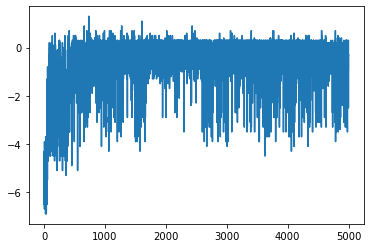

In [20]:
    
def trainQAC(env, agent, epochs=1000):
    done = False
    state = env.reset()

    returns = []
    for i in tqdm(range(epochs)):
        ret = 0
        while not done:
            a = agent.get_single_action(state, det=False)
            next_state, r, done, _ = env.step(a)
            agent.update(state, a, r, next_state, done)
            ret += r
            state = next_state
        done = False
        env.reset()
        returns.append(ret)
    
        if i%50 == 0:
            print(f"current average return is: {np.mean(returns)}")
    
    plt.plot(returns)
    plt.show()

    return agent, returns
   

agent = QActorCritic(
    buffer_size=5000,
    gamma=0.99,
    critic_lr=0.0005,
    actor_lr=0.0005,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    tau=0.95,
    warmup_step=500,
    critic_warmup=1000,
    eps=0.3,
    hs
)

gold_hunt_env = GoldHuntEnv(ascii_rep=False)
gold_hunt_env.reset()

qac, history = trainQAC(
    env = gold_hunt_env,
    agent=agent,
    epochs=5000
)


## playing

{'cum_r': -0.30000000000000004, 'action': 'agent performed Action.RIGHT', 'status': 'agent found the GOLD!', 'step': 12, 'statu': ''}


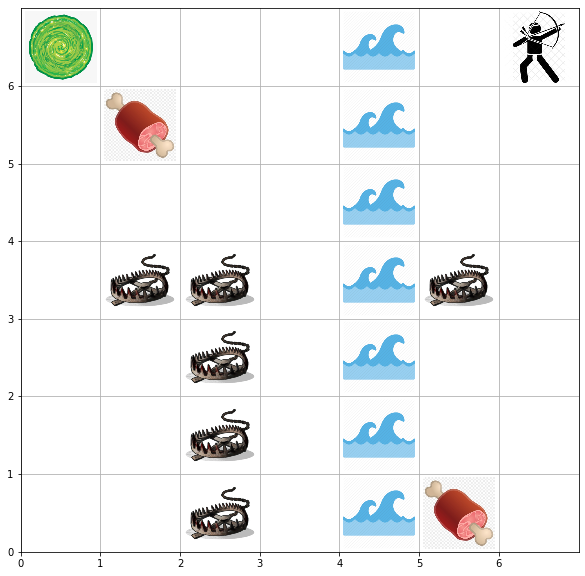

In [21]:
import time

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_single_action(state, det=False)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        
play(gold_hunt_env, qac)

## evaluating

In [22]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_single_action(state, det=False)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


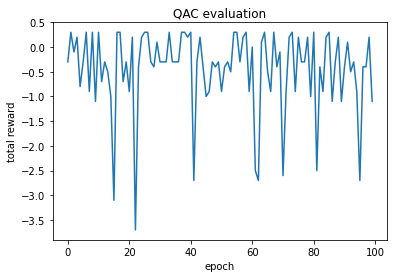

In [23]:
agent_tot = evaluate_det_policy(env, agent)

plt.plot(agent_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('QAC evaluation')


plt.show()


# Cartpole-v1

## training

In [5]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_single_action(state)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


def train_and_evaluate(env, agent, epochs, eval_step=100, early_stop_thr=470, eval_it=50):
    actor_losses = []
    critic_losses = []
    
    returns = []
    for i in tqdm(range(epochs)):
        done = False
        state = env.reset()
        
        ret = 0
        while not done:
            a = agent.get_single_action(state, det=False)
            next_state, r, done, _ = env.step(a)
            actor_loss, critic_loss = agent.update(state, a, r, next_state, done)
            if actor_loss is not None:
                actor_losses.append(actor_loss)
            if critic_loss is not None:
                critic_losses.append(critic_loss)
            
            ret += r
            state = next_state
        done = False
        returns.append(ret)
        
        if int(i+1)%100 == 0 and len(critic_losses)>0:
            avg_ret = np.mean(evaluate_det_policy(env, agent, k=eval_it))
            print(f"epoch:{i} buffer_size:{len(agent.buffer)} average return={avg_ret}")
            print(f"average critic loss: {np.mean(critic_losses)} - avergate actor loss: {np.mean(actor_losses)}")
            if avg_ret > early_stop_thr:
                return returns, actor_losses, critic_losses
            

    return returns, actor_losses, critic_losses



In [ ]:
env = gym.make('CartPole-v1')
done = False
state = env.reset()


agent = QActorCritic(
    buffer_size=3000,
    gamma=0.99,
    critic_lr=0.0005,
    actor_lr=0.00001,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=128,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    tau=0.99,
    warmup_step=1000,
)


returns, actor_losses, critic_losses = train_and_evaluate(env, agent, early_stop_thr=490, epochs=3000)


  3%|▎         | 87/3000 [00:03<01:58, 24.59it/s] 

epoch:99 buffer_size:2299 average return=21.7
average critic loss: 6.593307018280029 - avergate actor loss: nan


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 201/3000 [00:09<03:00, 15.54it/s]

epoch:199 buffer_size:3000 average return=24.82
average critic loss: 5.475198745727539 - avergate actor loss: nan


  9%|▉         | 265/3000 [00:17<06:30,  7.01it/s]

### evaluation graphs

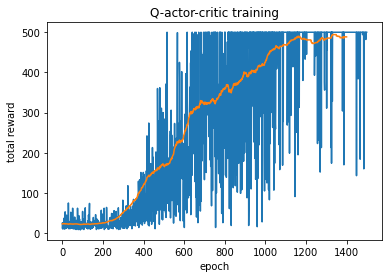

In [127]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.plot(returns)
plt.plot(moving_average(returns, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Q-actor-critic training')
plt.show()


### simulating environment

In [23]:
import time

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_action(state, det=True)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        


In [ ]:
play(env, agent)

### evaluating with deterministic policy

In [105]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_single_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


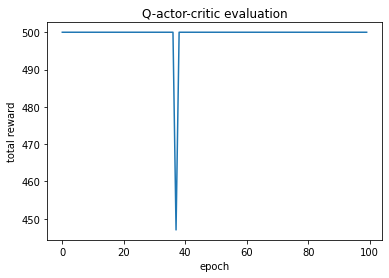

In [128]:
agent_tot = evaluate_det_policy(env, agent)

plt.plot(agent_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Q-actor-critic evaluation')
plt.show()


# LunarLander

## defining agents and training

In [131]:
env = gym.make('LunarLander-v2')
done = False
state = env.reset()


def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_single_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


def train_and_evaluate(env, agent, epochs, eval_step=100, early_stop_thr=470, eval_it=50):
    actor_losses = []
    critic_losses = []
    
    returns = []
    for i in tqdm(range(epochs)):
        done = False
        state = env.reset()
        
        ret = 0
        while not done:
            a = agent.get_single_action(state, det=False)
            next_state, r, done, _ = env.step(a)
            #TODO: reward shaping
            
#             r += 200
            r /= 100
            
            actor_loss, critic_loss = agent.update(state, a, r, next_state, done)
            if actor_loss is not None:
                actor_losses.append(actor_loss)
            if critic_loss is not None:
                critic_losses.append(critic_loss)
            
            ret += r
            state = next_state
        done = False
        returns.append(ret)
        
        if int(i+1)%50 == 0 and len(critic_losses)>0:
            avg_ret = np.mean(evaluate_det_policy(env, agent, k=eval_it))
            print(f"epoch:{i} buffer_size:{len(agent.buffer)} average return={avg_ret} current_eps:{agent.eps}")
            print(f"average critic loss: {np.mean(critic_losses)} - avergate actor loss: {np.mean(actor_losses)}")
            if avg_ret > early_stop_thr:
                return returns, actor_losses, critic_losses
            

    return returns, actor_losses, critic_losses


agent = QActorCritic(
    buffer_size=30000,
    gamma=0.99,
    critic_lr=3e-5,
    actor_lr=3e-5,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=64,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    tau=0.99,
    warmup_step=10000,
    critic_warmup=20000,
    hsize=300,
    eps=0.3
)



returns, actor_losses, critic_losses = train_and_evaluate(env, agent, early_stop_thr=180, eval_it=50, epochs=5000)


  3%|▎         | 150/5000 [00:14<41:36,  1.94it/s]

epoch:149 buffer_size:14157 average return=-181.02851513461485 current_eps:0.3
average critic loss: 0.006555583793669939 - avergate actor loss: nan


  4%|▍         | 200/5000 [00:28<36:53,  2.17it/s]

epoch:199 buffer_size:18618 average return=-200.4746839475772 current_eps:0.3
average critic loss: 0.006541744340211153 - avergate actor loss: nan


  5%|▌         | 250/5000 [00:55<1:10:44,  1.12it/s]

epoch:249 buffer_size:23317 average return=-200.76024124356053 current_eps:0.2896765521110954
average critic loss: 0.006152175832539797 - avergate actor loss: -1.2441656589508057


  6%|▌         | 300/5000 [01:31<3:01:23,  2.32s/it]

epoch:299 buffer_size:28190 average return=-440.3033543382992 current_eps:0.2755419667247846
average critic loss: 0.0053514521569013596 - avergate actor loss: -0.938372790813446


  7%|▋         | 350/5000 [04:38<40:56:30, 31.70s/it]

epoch:349 buffer_size:30000 average return=-53.09378213369998 current_eps:0.26209706955309414
average critic loss: 0.004260908346623182 - avergate actor loss: -0.32748937606811523


  8%|▊         | 400/5000 [08:33<18:56:26, 14.82s/it]

epoch:399 buffer_size:30000 average return=149.6592169843569 current_eps:0.2493082076928521
average critic loss: 0.0031980881467461586 - avergate actor loss: -0.076802559196949


 10%|█         | 500/5000 [15:00<10:46:49,  8.62s/it]

epoch:499 buffer_size:30000 average return=119.11931346048934 current_eps:0.2255721085314862
average critic loss: 0.0022272143978625536 - avergate actor loss: -0.00466819666326046


 11%|█         | 550/5000 [19:57<19:57:40, 16.15s/it]

epoch:549 buffer_size:30000 average return=155.158967036149 current_eps:0.21456545919942133
average critic loss: 0.0018396228551864624 - avergate actor loss: 0.01009028684347868


 12%|█▏        | 600/5000 [23:09<19:13:39, 15.73s/it]

epoch:599 buffer_size:30000 average return=167.43990021534864 current_eps:0.20409587240717011
average critic loss: 0.0016874297289177775 - avergate actor loss: 0.01590239815413952


 13%|█▎        | 650/5000 [28:33<22:14:22, 18.41s/it]

epoch:649 buffer_size:30000 average return=167.35109643183281 current_eps:0.1941371425254834
average critic loss: 0.0014853962929919362 - avergate actor loss: 0.022337110713124275


 14%|█▍        | 700/5000 [33:53<28:58:57, 24.26s/it]

epoch:699 buffer_size:30000 average return=17.135999508715987 current_eps:0.18466434261232895
average critic loss: 0.001339943497441709 - avergate actor loss: 0.0236689280718565


 15%|█▌        | 750/5000 [39:37<25:03:22, 21.22s/it]

epoch:749 buffer_size:30000 average return=149.21361241310527 current_eps:0.1756537620201522
average critic loss: 0.0012499134754762053 - avergate actor loss: 0.025646058842539787


 17%|█▋        | 850/5000 [48:27<22:33:20, 19.57s/it]

epoch:849 buffer_size:30000 average return=177.94577522889617 current_eps:0.158930144486814
average critic loss: 0.0011183624155819416 - avergate actor loss: 0.02627289667725563


 18%|█▊        | 899/5000 [53:37<4:04:35,  3.58s/it] 

epoch:899 buffer_size:30000 average return=188.73616992406278 current_eps:0.15117524792602494
average critic loss: 0.0010720060672610998 - avergate actor loss: 0.027428368106484413


## performance comparison

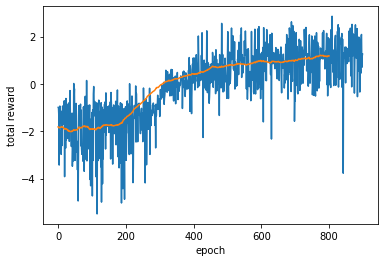

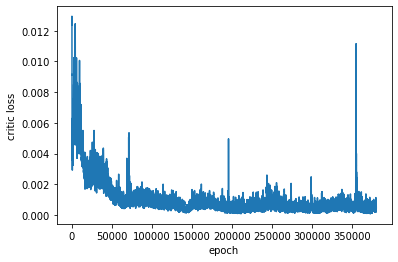

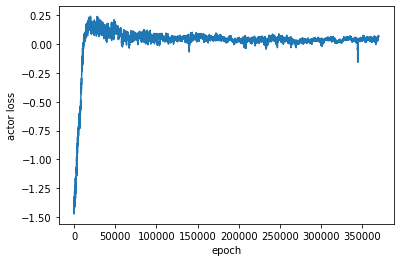

In [133]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



plt.plot(returns)
plt.plot(moving_average(returns, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.show()


plt.plot(moving_average(critic_losses, n=100))
plt.xlabel('epoch')
plt.ylabel('critic loss')
plt.show()

plt.plot(moving_average(actor_losses, n=100))
plt.xlabel('epoch')
plt.ylabel('actor loss')
plt.show()

### simulating environment

In [ ]:
import time


def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_action(state, det=True)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        
play(env, agent)

### evaluating with deterministic policy

In [140]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_single_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


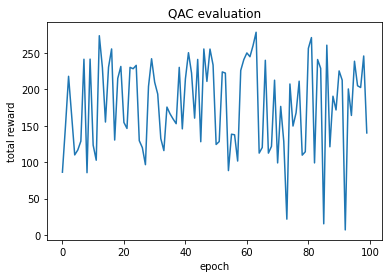

In [141]:
agent_tot = evaluate_det_policy(env, agent)

plt.plot(agent_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('QAC evaluation')


plt.show()


# SAC

In [43]:

class SAC:
    def __init__(self, tau, buffer_size, gamma, actor_lr, critic_lr, state_size, action_size, batch_size,
                 device, warmup_step=1000, hsize=100, verbose=0, critic_warmup=5000, eps=0.5, min_eps=0.05, alpha=0.5):

        self.max_buffer_size = buffer_size
        self.gamma = torch.tensor(gamma)
        
        self.buffer = deque()
        self.action_size = action_size
        self.state_size = state_size
        self.critic_warmup = critic_warmup
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.tau = tau
        self.min_eps = min_eps
        self.eps = eps
        self.alpha = alpha
        
        self.q1 = FCNet(state_size, action_size, hsize)
        self.q1_target = FCNet(state_size, action_size, hsize)
        self.q1.to(self.device)
        self.q1_target.to(self.device)
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.critic1_opt = optim.Adam(self.q1.parameters(), lr=critic_lr)
        
        self.q2 = FCNet(state_size, action_size, hsize)
        self.q2_target = FCNet(state_size, action_size, hsize)
        self.q2.to(self.device)
        self.q2_target.to(self.device)
        self.q2_target.load_state_dict(self.q2.state_dict())
        self.critic2_opt = optim.Adam(self.q2.parameters(), lr=critic_lr)
        
        self.actor = FCNet(state_size, action_size, hsize, last_activation='softmax')
        self.actor.to(self.device)
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        self.update_step = 0
        self.warmup_step = warmup_step
        
        
        
    def get_q_val(self, qnet, state, action=None):
        if action is None:
            return qnet(state)
        return qnet(state).gather(1, action.reshape(-1,1).long())
        
        
    def get_ensemble_q_val(self, state, action=None, mode='target'):
        if mode=='target':
            q1_vals = self.q1_target(state).gather(1, action.reshape(-1,1).long())
            q2_vals = self.q2_target(state).gather(1, action.reshape(-1,1).long())
        else:
            q1_vals = self.q1(state).gather(1, action.reshape(-1,1).long())
            q2_vals = self.q2(state).gather(1, action.reshape(-1,1).long())
        
            
        #TODO: works?
        return torch.min(q1_vals, q2_vals)

    def add_to_buffer(self, experience):
        if len(self.buffer) >= self.max_buffer_size:
            self.buffer.pop()
        self.buffer.appendleft(experience)
        
    def _np_to_tensor(self, nparrs):
        return [torch.from_numpy(arr).float().to(self.device) for arr in nparrs]
        
    def sample_minibatch(self):
        idxs = np.random.randint(0, len(self.buffer), self.batch_size)
        sample = [self.buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*sample)))
        return tuple(self._np_to_tensor([states, actions, rewards, next_states, dones]))
        
    def get_action(self, state, det=False):
        """
        if det=False it will sample based on output probabilities of policy function
        """
#         state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            if not det:
                dist = Categorical(self.policy(state))
                actions = dist.sample()
            else:
                actions = torch.argmax(self.policy(state), dim=1)
            
            return actions
        

    def get_single_action(self, state, det=False):
        if self.update_step < self.critic_warmup:
            return np.random.randint(self.action_size)
        
        if random() < self.eps:
            return np.random.randint(self.action_size)
        
        state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            if not det:
                dist = Categorical(self.policy(state))
                action = dist.sample()
            else:
                action = torch.argmax(self.policy(state), dim=1)
            
        return action.cpu().numpy()[0]
    
    def policy(self, state):
        return self.actor(state)
    
    def synchronize(self):
        with torch.no_grad():
            params = self.q1.parameters()
            targ_params = self.q1_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
                
            params = self.q2.parameters()
            targ_params = self.q2_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
            
        
    def update_critic(self, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
        with torch.no_grad():
            last_step_target = batch_dones * batch_rewards
                        
            next_actions = self.get_action(batch_next_states, det=False)
                        
            next_action_probs = self.policy(batch_next_states)
            next_action_logprobs = Categorical(next_action_probs).log_prob(next_actions)
            
            middle_step_target = (1-batch_dones)*(batch_rewards + self.gamma*(
                    self.get_ensemble_q_val(batch_next_states, next_actions).squeeze() - self.alpha*next_action_logprobs))
            targets =  last_step_target + middle_step_target
        
        p1 = self.get_q_val(self.q1, batch_states, batch_actions).squeeze()
        loss1 = F.mse_loss(p1, targets)
        self.critic1_opt.zero_grad()
        loss1.backward()
        self.critic1_opt.step()
        
        p2 = self.get_q_val(self.q2, batch_states, batch_actions).squeeze()
        loss2 = F.mse_loss(p2, targets)
        self.critic2_opt.zero_grad()
        loss2.backward()
        self.critic2_opt.step()
        
        self.synchronize()
        
        return ((loss1+loss2)/2).detach().cpu().numpy()
    

    def update_actor(self, batch_states):
        
        dist = Categorical(self.policy(batch_states))
        actions = dist.sample()
        
        with torch.no_grad():
            qmin = self.get_ensemble_q_val(batch_states, actions, mode='online').squeeze()
            
        action_logprobs = dist.log_prob(actions)
        loss = -torch.mean(qmin - self.alpha*action_logprobs)
        
        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
        
        return loss.detach().cpu().numpy()
    
    
    def update(self, state, action, reward, next_state, done):
        self.update_step += 1
    
        self.add_to_buffer([state, action, reward, next_state, done])
        
        if len(self.buffer) < self.warmup_step:
            return None, None         


        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = self.sample_minibatch()

        if self.update_step < self.critic_warmup:
            critic_loss = self.update_critic(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
            return None, critic_loss

        if done:
            self.eps = max(self.min_eps, self.eps*0.999)
            self.alpha = max(self.alpha, self.alpha*0.999)
        
        critic_loss = self.update_critic(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
        actor_loss = self.update_actor(batch_states)
        
        return actor_loss, critic_loss


In [44]:

def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_single_action(state)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


def train_and_evaluate(env, agent, epochs, eval_step=100, early_stop_thr=470, eval_it=50):
    actor_losses = []
    critic_losses = []
    
    returns = []
    for i in tqdm(range(epochs)):
        done = False
        state = env.reset()
        
        ret = 0
        while not done:
            a = agent.get_single_action(state, det=False)
            next_state, r, done, _ = env.step(a)
            actor_loss, critic_loss = agent.update(state, a, r, next_state, done)
            if actor_loss is not None:
                actor_losses.append(actor_loss)
            if critic_loss is not None:
                critic_losses.append(critic_loss)
            
            ret += r
            state = next_state
        done = False
        returns.append(ret)
        
        if int(i+1)%100 == 0 and len(critic_losses)>0:
            avg_ret = np.mean(evaluate_det_policy(env, agent, k=eval_it))
            print(f"epoch:{i} buffer_size:{len(agent.buffer)} average return={avg_ret}")
            print(f"average critic loss: {np.mean(critic_losses)} - avergate actor loss: {np.mean(actor_losses)}")
            print(f"current eps: {agent.eps}")
            if avg_ret > early_stop_thr:
                return returns, actor_losses, critic_losses
            

    return returns, actor_losses, critic_losses



In [48]:
env = gym.make('CartPole-v1')
done = False
state = env.reset()


agent = SAC(
    buffer_size=5000,
    gamma=0.99,
    critic_lr=0.0001,
    actor_lr=0.0001,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=128,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    tau=0.99,
    eps=0.05,
    alpha=0.3,
    warmup_step=1000,
    critic_warmup=5000,
    
)


returns, actor_losses, critic_losses = train_and_evaluate(env, agent, eval_step=100, early_stop_thr=490, epochs=3000)


  3%|▎          | 99/3000 [00:04<03:01, 15.96it/s]

epoch:99 buffer_size:2091 average return=22.86
average critic loss: 7.901791095733643 - avergate actor loss: nan
current eps: 0.05


  7%|▋         | 200/3000 [00:24<09:30,  4.91it/s]

epoch:199 buffer_size:4153 average return=21.1
average critic loss: 7.910516738891602 - avergate actor loss: nan
current eps: 0.05


 10%|█         | 301/3000 [01:07<11:02,  4.07it/s]

epoch:299 buffer_size:5000 average return=23.58
average critic loss: 7.141907691955566 - avergate actor loss: -14.902531623840332
current eps: 0.05


 13%|█▎        | 400/3000 [01:38<06:20,  6.84it/s]

epoch:399 buffer_size:5000 average return=20.12
average critic loss: 6.524250030517578 - avergate actor loss: -14.266878128051758
current eps: 0.05


 17%|█▋        | 500/3000 [02:09<30:04,  1.39it/s]

epoch:499 buffer_size:5000 average return=20.74
average critic loss: 6.18953800201416 - avergate actor loss: -14.217937469482422
current eps: 0.05


 20%|██        | 600/3000 [02:34<06:25,  6.22it/s]

epoch:599 buffer_size:5000 average return=23.34
average critic loss: 5.879397869110107 - avergate actor loss: -14.127279281616211
current eps: 0.05


 23%|██▎       | 700/3000 [03:13<08:51,  4.33it/s]

epoch:699 buffer_size:5000 average return=22.78
average critic loss: 5.680109024047852 - avergate actor loss: -14.127220153808594
current eps: 0.05


 27%|██▋       | 801/3000 [04:01<21:30,  1.70it/s]

epoch:799 buffer_size:5000 average return=25.6
average critic loss: 5.566107273101807 - avergate actor loss: -14.221783638000488
current eps: 0.05


 30%|███       | 901/3000 [04:55<13:07,  2.66it/s]

epoch:899 buffer_size:5000 average return=20.28
average critic loss: 5.423823356628418 - avergate actor loss: -14.21342945098877
current eps: 0.05


 33%|███      | 1000/3000 [05:40<10:59,  3.03it/s]

epoch:999 buffer_size:5000 average return=18.6
average critic loss: 5.27200174331665 - avergate actor loss: -14.136866569519043
current eps: 0.05


 37%|███▎     | 1100/3000 [06:32<04:41,  6.76it/s]

epoch:1099 buffer_size:5000 average return=20.52
average critic loss: 5.142843723297119 - avergate actor loss: -14.024523735046387
current eps: 0.05


 40%|███▌     | 1201/3000 [07:12<04:49,  6.21it/s]

epoch:1199 buffer_size:5000 average return=21.56
average critic loss: 5.049874782562256 - avergate actor loss: -13.938525199890137
current eps: 0.05


 43%|███▉     | 1300/3000 [07:55<14:26,  1.96it/s]

epoch:1299 buffer_size:5000 average return=24.08
average critic loss: 5.014802932739258 - avergate actor loss: -14.001623153686523
current eps: 0.05


 47%|████▏    | 1401/3000 [08:36<10:07,  2.63it/s]

epoch:1399 buffer_size:5000 average return=20.86
average critic loss: 4.987873554229736 - avergate actor loss: -14.074984550476074
current eps: 0.05


 50%|████▌    | 1500/3000 [09:15<10:48,  2.31it/s]

epoch:1499 buffer_size:5000 average return=21.54
average critic loss: 4.9723334312438965 - avergate actor loss: -14.161355972290039
current eps: 0.05


 53%|████▊    | 1594/3000 [09:52<08:43,  2.69it/s]


KeyboardInterrupt: 

# Rainbow DQN

## imports

In [8]:

import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

from segment_tree import MinSegmentTree, SumSegmentTree

## replay buffer

In [9]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 1, 
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )
    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

In [10]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    
    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        alpha: float = 0.6,
        n_step: int = 1, 
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(
        self, 
        obs: np.ndarray, 
        act: int, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

## noisy layer

In [11]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    
        
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

## noisy net + dueling net + categorical dqn


In [12]:
class Network(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()
        
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
        )
        
        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(128, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(128, 128)
        self.value_layer = NoisyLinear(128, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        
        return q
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x)
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))
        
        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans
        
        return dist
    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

## Rainbow agent

In [13]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        gamma: float = 0.99,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(
            torch.FloatTensor(state).to(self.device)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            
            # NoisyNet: removed decrease of epsilon
            
            # PER: increase beta
            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses)
                
        self.env.close()
                
    def test(self) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.show()

## training

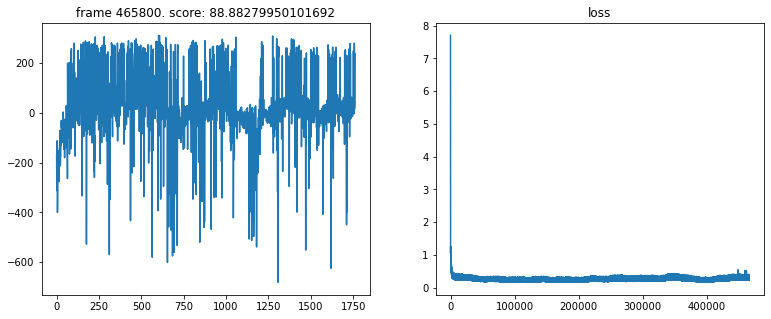

KeyboardInterrupt: 

In [17]:
env_id = "LunarLander-v2"
env = gym.make(env_id)

# parameters
num_frames = 1000000
memory_size = 20000
batch_size = 32
target_update = 100

# train
agent = DQNAgent(env, memory_size, batch_size, target_update)
agent.train(num_frames)